In [10]:
import sys
import copy
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from loaders.Loaders import CSVLoader
from standardizer.CustomStandardizer import CustomStandardizer
from scalers.sklearnScalers import StandardScaler
from compoundFeaturization.rdkitDescriptors import TwoDimensionDescriptors
from compoundFeaturization.rdkitFingerprints import MorganFingerprint, RDKFingerprint, MACCSkeysFingerprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, explained_variance_score)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

sys.path.append('src')

# LOAD DeepMol

In [11]:
rdk_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]

str_bits = list(str(x) for x in bits)

In [12]:
loader = CSVLoader(rdk_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)

In [13]:
dataset = loader.create_dataset()

In [14]:
dataset.get_shape()

Mols_shape:  39990
Features_shape:  (39990, 205)
Labels_shape:  (39990,)


# ML

In [15]:
def ml(model, data_train, data_test, label_train, label_test, param=None):
    # k-fold
    kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    # Cross validation
    scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
    print(f'Cross Validation Accuracy score: {np.mean(scores_scoring)}\n')

    # model training - FIT
    model.fit(data_train, label_train)

    # PREDICT
    predict = model.predict(X=data_test)

    base_model = accuracy_score(label_test, predict)
    print('Base Model Accuracy: {:.3f}\n'.format(base_model))

    if param != None:
        ## OPTIMIZATION

        search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='accuracy', random_state=None, n_jobs=4)
        search.fit(X=data_train, y=label_train)

        # OPTI MODEL FITTED
        best_model = search.best_estimator_
        predict_opt = best_model.predict(X=data_test)

        opt_model = accuracy_score(label_test, predict_opt)
        print('Optimized Model Accuracy: {:.3f}\n'.format(opt_model))

        improv = ((opt_model-base_model)/base_model*100)
        print('Optimized model improved {:.3f}% over base model.\n'.format(improv))

        if improv >= 0:
            return search
    return model

In [16]:
rf = RandomForestClassifier(n_jobs=4)
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'],
          'bootstrap': [True, False]}

In [17]:
fingerprint = pd.read_csv('../dataset/binary_class/rdk_fs.csv', sep=',')
fingerprint_data_b = fingerprint.drop("activity", axis=1)
fingerprint_label_b = fingerprint["activity"]

In [18]:
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_b, fingerprint_label_b, test_size=0.3)

In [19]:
model = ml(rf, data_train, data_test, label_train, label_test, param=None)

Cross Validation Accuracy score: 0.8055583280865817

Base Model Accuracy: 0.811



# SHAP

In [20]:
# rdk = pd.read_csv('/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv')
# rdk[19963:20023]
# rdk[19963:20023].to_csv('/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/shap_mole.csv', index=False)

In [21]:
mole_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/shap_mole.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]
str_bits = [str(x) for x in bits]

loader_mole = CSVLoader(mole_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)
mole = loader_mole.create_dataset()
mole.get_shape()

Mols_shape:  61
Features_shape:  (61, 205)
Labels_shape:  (61,)


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- feat_1
- feat_10
- feat_100
- feat_101
- feat_102
- ...
Feature names seen at fit time, yet now missing:
- 0
- 101
- 1016
- 1024
- 103
- ...

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- feat_1
- feat_10
- feat_100
- feat_101
- feat_102
- ...
Feature names seen at fit time, yet now missing:
- 0
- 101
- 1016
- 1024
- 103
- ...

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- feat_1
- feat_10
- feat_100
- feat_101
- feat_102
- ...
Feature names seen at fit time, yet now missing:
- 0
- 101
- 1016
- 1024
- 103
- ...

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names 

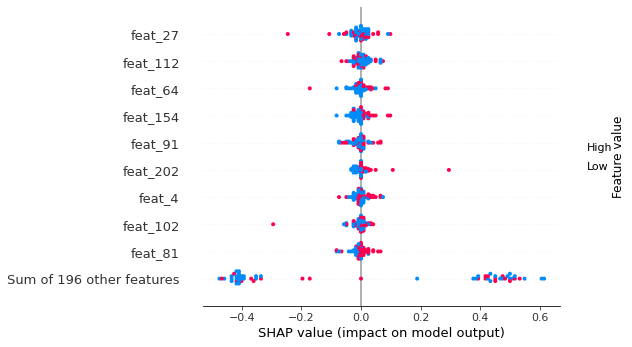

In [22]:
from featureImportance.shapValues import ShapValues

shap_calc = ShapValues(mole, rf)
shap_calc.computePermutationShap()

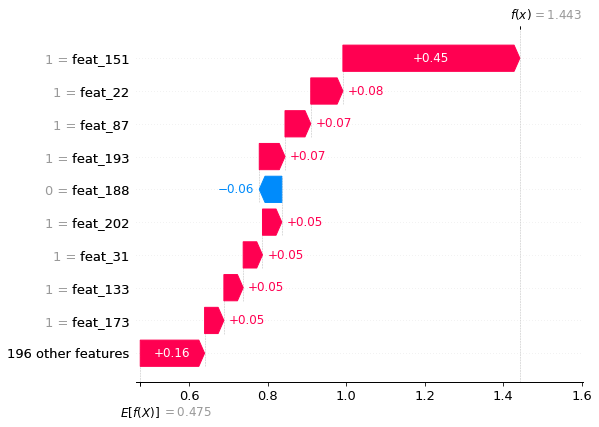

In [23]:
shap_calc.plotSampleExplanation(index=1, plot_type='waterfall')

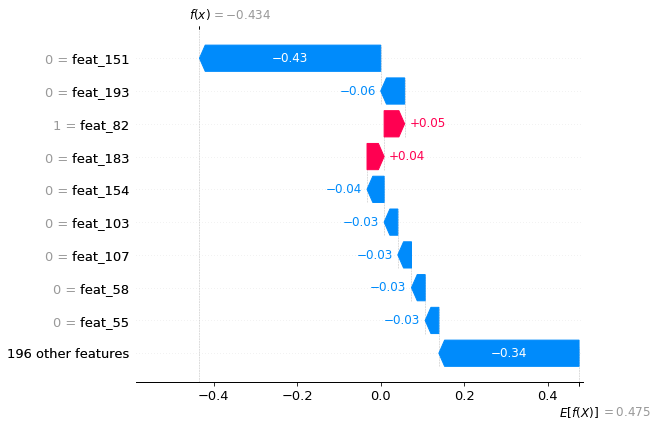

In [24]:
shap_calc.plotSampleExplanation(index=57, plot_type='waterfall')

2022-01-14 22:13:44.893675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-01-14 22:13:44.893696: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


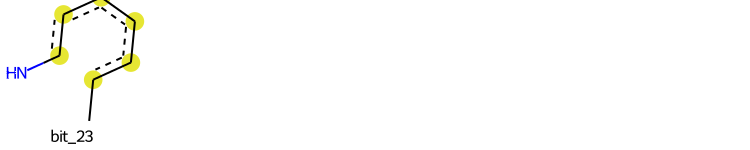

In [25]:
from utils.utils import draw_rdk_bits, draw_rdk_bit_on_molecule

draw_rdk_bits(mole.mols[1], [23])

Bit 23 with 1 hits!


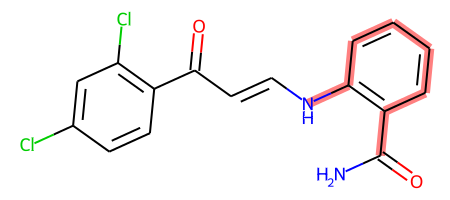

In [26]:
draw_rdk_bit_on_molecule(mole.mols[1], 23)

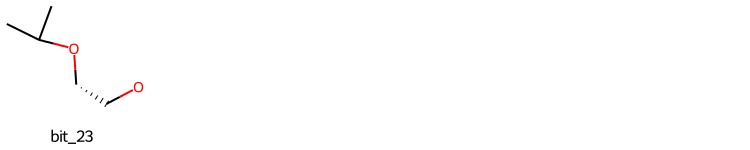

In [27]:
draw_rdk_bits(mole.mols[57], [23])

Bit 23 with 3 hits!


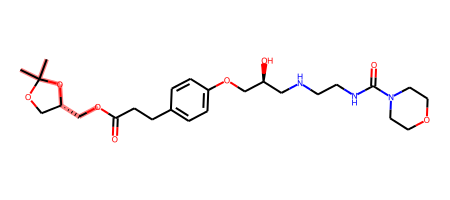

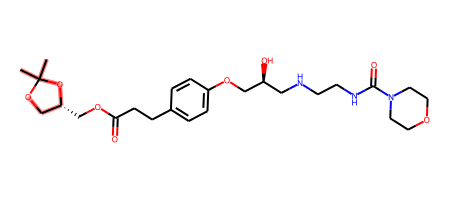

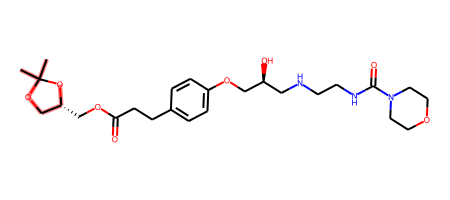

In [28]:
draw_rdk_bit_on_molecule(mole.mols[57], 23)